
# Car Body Type Classification - Classical Machine Learning
# Project number : 82


| Name                    | Student ID |
|-------------------------|------------|
| Kenzy Tamer Ahmed       | 22P0179    |
| Yasmeen Tamer Abdelazim | 22P0057    |

## 1️ Import Libraries

In [25]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from skimage.feature import local_binary_pattern
from sklearn.neural_network import MLPClassifier

## 2 Feature Extraction Function

In [26]:
def extract_features(img_path):
    """
    Extract handcrafted features from an image:
    - HOG for shape/edges
    - HSV histogram for color
    """
    img = cv2.imread(img_path)
    img = cv2.resize(img, (160, 160))

    # ---- HOG (Shape features) ----
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True
    )

    # ---- HSV Color Histogram ----
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # ---- LBP (Texture) ----
    lbp = local_binary_pattern(
        gray,
        P=8,
        R=1,
        method='uniform'
    )
    lbp_hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, 11),
        range=(0, 10)
    )
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    # ---- Combine features ----
    return np.hstack([hog_features, hist,lbp_hist])


## 3 Load Dataset from Folders

In [27]:
def load_dataset(folder_path):
    """
    Loads images and extracts features from a folder structure:
    folder_path/
        Class1/
            img1.jpg, img2.jpg...
        Class2/
            ...

    Args:
        folder_path (str): path to train/val/test folder

    Returns:
        X (np.array): feature vectors
        y (list): class labels (folder names)
    """
    X, y = [], []
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            features = extract_features(img_path)
            X.append(features)
            y.append(class_name)

    return np.array(X), np.array(y)
# Paths to your dataset folders
train_dir = "dataset/train"
val_dir = "dataset/valid"
test_dir = "dataset/test"

# Load datasets
X_train, y_train = load_dataset(train_dir)
X_val, y_val = load_dataset(val_dir)
X_test, y_test = load_dataset(test_dir)

print("Dataset shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)
print(np.unique(y_train))



Dataset shapes:
X_train: (5350, 3438) y_train: (5350,)
X_val: (1397, 3438) y_val: (1397,)
X_test: (802, 3438) y_test: (802,)
['Convertible' 'Coupe' 'Hatchback' 'Pick-Up' 'SUV' 'Sedan' 'VAN']


## 4 Encode Labels

In [28]:
# Convert class names to integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

## 5 Shuflling Dataset

In [29]:
X_train, y_train_enc = shuffle(X_train, y_train_enc, random_state=42)
X_val, y_val_enc = shuffle(X_val, y_val_enc, random_state=42)
X_test, y_test_enc = shuffle(X_test, y_test_enc, random_state=42)

## 6 Feature Selection

In [30]:
# Remove near-constant features
var_thresh = VarianceThreshold(threshold=0.01)
X_train_sel = var_thresh.fit_transform(X_train)
X_val_sel   = var_thresh.transform(X_val)
X_test_sel  = var_thresh.transform(X_test)

# Select top-k features (safe k)
k = min(200, X_train_sel.shape[1])
k_best = SelectKBest(score_func=f_classif, k=k)

X_train_sel = k_best.fit_transform(X_train_sel, y_train_enc)
X_val_sel   = k_best.transform(X_val_sel)
X_test_sel  = k_best.transform(X_test_sel)

print("After selection:", X_train_sel.shape)


After selection: (5350, 200)


## 7 Feature Scaling

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_val_scaled = scaler.transform(X_val_sel)
X_test_scaled = scaler.transform(X_test_sel)

## 8 Dimensionality Reduction with PCA

In [32]:
pca = PCA(n_components=0.98, random_state=42)  # keep 98% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Feature dimensions after PCA:", X_train_pca.shape)

Feature dimensions after PCA: (5350, 119)


## 9 Train Classical ML Models

### SVM Model

SVM Validation Accuracy: 0.7387258410880458
SVM Test Accuracy: 0.7206982543640897
              precision    recall  f1-score   support

 Convertible       0.80      0.80      0.80       174
       Coupe       0.46      0.58      0.51        79
   Hatchback       0.68      0.64      0.66        99
     Pick-Up       0.74      0.78      0.76       110
         SUV       0.74      0.66      0.69       125
       Sedan       0.62      0.60      0.61       109
         VAN       0.94      0.91      0.92       106

    accuracy                           0.72       802
   macro avg       0.71      0.71      0.71       802
weighted avg       0.73      0.72      0.72       802



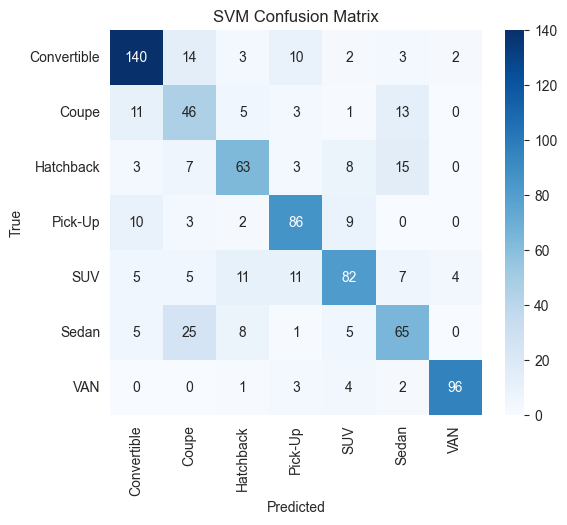

In [33]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale')

# Train
svm_model.fit(X_train_pca, y_train_enc)

# Validation
y_val_pred = svm_model.predict(X_val_pca)
svm_val_acc = accuracy_score(y_val_enc, y_val_pred)
print("SVM Validation Accuracy:", svm_val_acc)

# Testing
y_test_pred = svm_model.predict(X_test_pca)
svm_test_acc = accuracy_score(y_test_enc, y_test_pred)
print("SVM Test Accuracy:", svm_test_acc)

print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix")
plt.show()


### Random Forest Model

RF Validation Accuracy: 0.5733715103793844
RF Test Accuracy: 0.5349127182044888
              precision    recall  f1-score   support

 Convertible       0.61      0.66      0.64       174
       Coupe       0.30      0.34      0.32        79
   Hatchback       0.49      0.37      0.43        99
     Pick-Up       0.50      0.57      0.54       110
         SUV       0.46      0.46      0.46       125
       Sedan       0.48      0.39      0.43       109
         VAN       0.78      0.82      0.80       106

    accuracy                           0.53       802
   macro avg       0.52      0.52      0.52       802
weighted avg       0.53      0.53      0.53       802



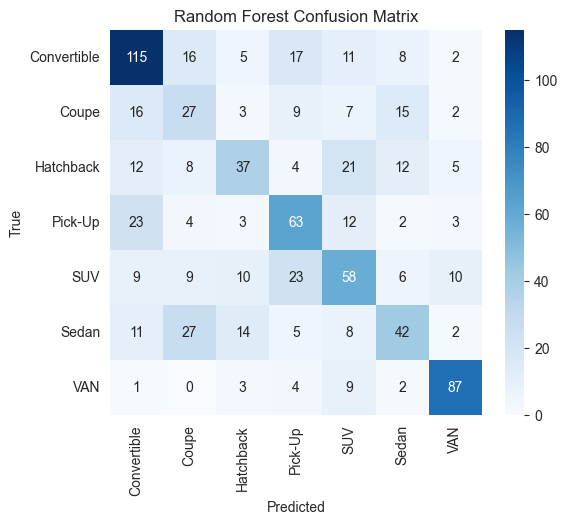

In [34]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Train
rf_model.fit(X_train_pca, y_train_enc)

# Validation
y_val_pred = rf_model.predict(X_val_pca)
rf_val_acc = accuracy_score(y_val_enc, y_val_pred)
print("RF Validation Accuracy:", rf_val_acc)

# Testing
y_test_pred = rf_model.predict(X_test_pca)
rf_test_acc = accuracy_score(y_test_enc, y_test_pred)
print("RF Test Accuracy:", rf_test_acc)

print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

### KNN Model

KNN Validation Accuracy: 0.5977093772369363
KNN Test Accuracy: 0.5773067331670823
              precision    recall  f1-score   support

 Convertible       0.69      0.61      0.65       174
       Coupe       0.34      0.51      0.41        79
   Hatchback       0.53      0.42      0.47        99
     Pick-Up       0.55      0.80      0.65       110
         SUV       0.54      0.38      0.45       125
       Sedan       0.49      0.51      0.50       109
         VAN       0.94      0.77      0.85       106

    accuracy                           0.58       802
   macro avg       0.58      0.57      0.57       802
weighted avg       0.60      0.58      0.58       802



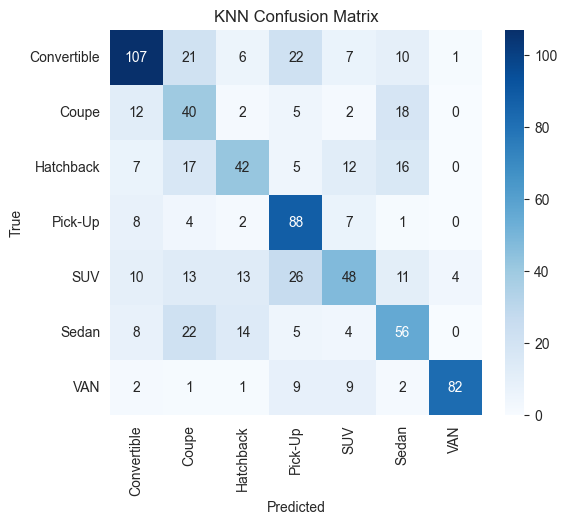

In [35]:
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train
knn_model.fit(X_train_pca, y_train_enc)

# Validation
y_val_pred = knn_model.predict(X_val_pca)
knn_val_acc = accuracy_score(y_val_enc, y_val_pred)
print("KNN Validation Accuracy:", knn_val_acc)

# Testing
y_test_pred = knn_model.predict(X_test_pca)
knn_test_acc = accuracy_score(y_test_enc, y_test_pred)
print("KNN Test Accuracy:", knn_test_acc)

print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))


# ---- Confusion Matrix ----
cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("KNN Confusion Matrix")
plt.show()



### XGBoost Model

XGBoost Validation Accuracy: 0.642806012884753
XGBoost Test Accuracy: 0.5985037406483791
              precision    recall  f1-score   support

 Convertible       0.75      0.74      0.74       174
       Coupe       0.31      0.38      0.34        79
   Hatchback       0.50      0.43      0.46        99
     Pick-Up       0.59      0.71      0.64       110
         SUV       0.55      0.50      0.53       125
       Sedan       0.51      0.50      0.50       109
         VAN       0.87      0.79      0.83       106

    accuracy                           0.60       802
   macro avg       0.58      0.58      0.58       802
weighted avg       0.61      0.60      0.60       802



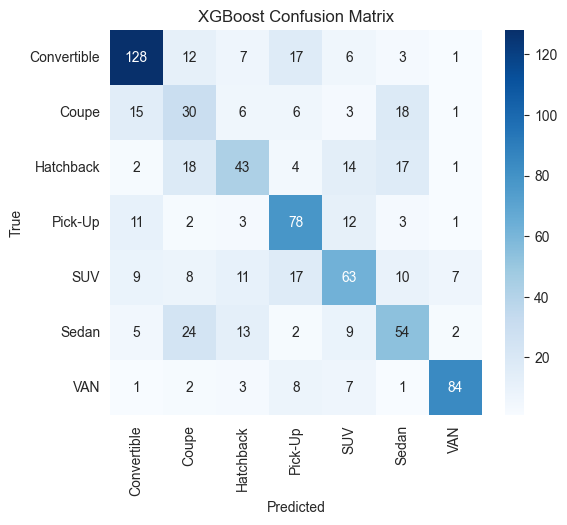

In [36]:
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)

# Train
xgb_model.fit(X_train_pca, y_train_enc)

# Validation
y_val_pred = xgb_model.predict(X_val_pca)
xgb_val_acc = accuracy_score(y_val_enc, y_val_pred)
print("XGBoost Validation Accuracy:", xgb_val_acc)

# Testing
y_test_pred = xgb_model.predict(X_test_pca)
xgb_test_acc = accuracy_score(y_test_enc, y_test_pred)
print("XGBoost Test Accuracy:", xgb_test_acc)

print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("XGBoost Confusion Matrix")
plt.show()


### ANN (MLP) Model

ANN Validation Accuracy: 0.6800286327845383
ANN Test Accuracy: 0.6620947630922693
              precision    recall  f1-score   support

 Convertible       0.77      0.74      0.75       174
       Coupe       0.40      0.51      0.45        79
   Hatchback       0.52      0.45      0.48        99
     Pick-Up       0.69      0.75      0.72       110
         SUV       0.64      0.59      0.62       125
       Sedan       0.59      0.62      0.60       109
         VAN       0.94      0.89      0.91       106

    accuracy                           0.66       802
   macro avg       0.65      0.65      0.65       802
weighted avg       0.67      0.66      0.66       802



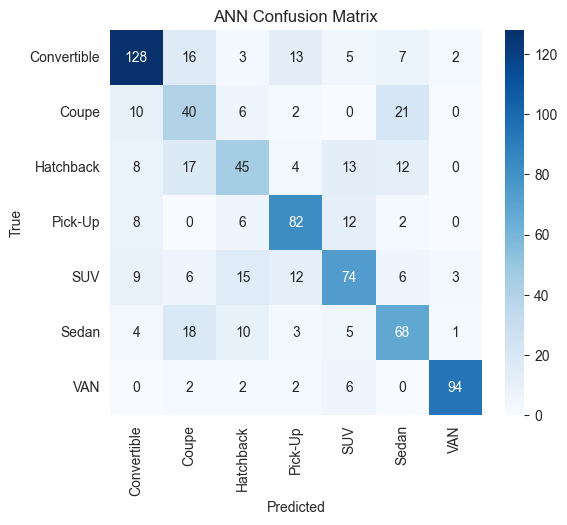

In [37]:
ann_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

# Train
ann_model.fit(X_train_pca, y_train_enc)

# Validation
y_val_pred = ann_model.predict(X_val_pca)
ann_val_acc = accuracy_score(y_val_enc, y_val_pred)
print("ANN Validation Accuracy:", ann_val_acc)

# Testing
y_test_pred = ann_model.predict(X_test_pca)
ann_test_acc = accuracy_score(y_test_enc, y_test_pred)
print("ANN Test Accuracy:", ann_test_acc)

print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ANN Confusion Matrix")
plt.show()


## SVM Tuning

Best SVM Params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV Accuracy: 0.7179429623910257
Tuned SVM Test Accuracy: 0.7605985037406484
              precision    recall  f1-score   support

 Convertible       0.82      0.84      0.83       174
       Coupe       0.57      0.65      0.61        79
   Hatchback       0.65      0.67      0.66        99
     Pick-Up       0.78      0.79      0.78       110
         SUV       0.74      0.70      0.72       125
       Sedan       0.74      0.69      0.71       109
         VAN       0.95      0.92      0.94       106

    accuracy                           0.76       802
   macro avg       0.75      0.75      0.75       802
weighted avg       0.76      0.76      0.76       802



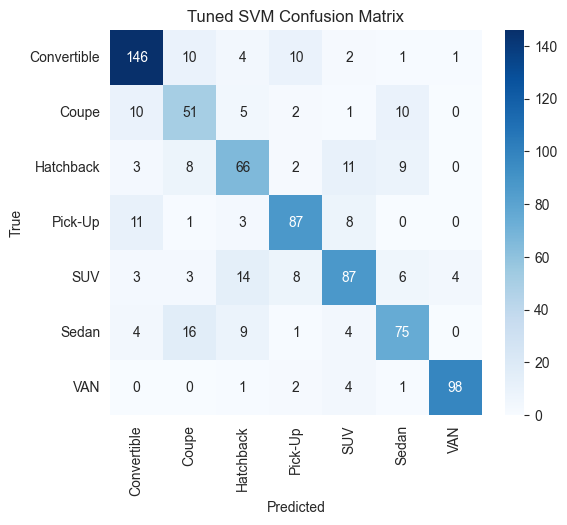

In [38]:
## Tuned SVM using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 50],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(
    SVC(),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_pca, y_train_enc)

svm_tuned = grid.best_estimator_

print("Best SVM Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

y_test_pred = svm_tuned.predict(X_test_pca)
svm_tuned_test_acc = accuracy_score(y_test_enc, y_test_pred)

print("Tuned SVM Test Accuracy:", svm_tuned_test_acc)
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Tuned SVM Confusion Matrix")
plt.show()

## Comparison

In [39]:
## Model Comparison (Test Accuracy)
models_dict = {
    "SVM": svm_model,
    "SVM (Tuned)": svm_tuned,
    "Random Forest": rf_model,
    "KNN": knn_model,
    "XGBoost": xgb_model,
    "ANN": ann_model
}

results = {
    "SVM": svm_test_acc,
    "SVM (Tuned)": svm_tuned_test_acc,
    "Random Forest": rf_test_acc,
    "KNN": knn_test_acc,
    "XGBoost": xgb_test_acc,
    "ANN": ann_test_acc
}

for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

SVM: 0.7207
SVM (Tuned): 0.7606
Random Forest: 0.5349
KNN: 0.5773
XGBoost: 0.5985
ANN: 0.6621
